In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd drive/MyDrive/colab_final_project/

/content/drive/MyDrive/colab_final_project


In [ ]:
!pip install tensorflow==2.13.0
!pip install protobuf==3.20.3
!pip install nltk==3.7
!pip install numpy==1.23.3
!pip install langdetect==1.0.9
!pip install pymongo
!pip install emoji
!pip install mysql-connector-python==8.0.33
!pip install scikeras

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 77, in main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
  File "/usr/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk.classify.util as util
import itertools
import pickle
from nltk.probability import FreqDist
import os.path
from statistics import mode
from nltk.classify import ClassifierI
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.probability import FreqDist
import numpy as np
import re
import math
import pandas as pd
import csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Dropout, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [15]:
emoji_dict = {}
with open('emoji.txt', 'r', encoding='latin-1') as emoji_file:
  for line in emoji_file:
    line = line.strip()
    if line:
      emoji, value = line.split('\t')
      emoji_dict[emoji] = int(value)

In [16]:
def replace_emojis(text, emoji_dict):
  for emoji, value in emoji_dict.items():
    if value == 1:
      text = re.sub(re.escape(emoji), 'happy', text)
    elif value == -1:
      text = re.sub(re.escape(emoji), 'sad', text)
  return text

In [17]:
#vincent
def get_wordnet_pos(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return None

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    words = word_tokenize(text)
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    lemmatizer = WordNetLemmatizer()
    tagged = pos_tag(words)
    words = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos)) if get_wordnet_pos(pos) else word for word, pos in tagged]
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

hatefulCorpus=[]
nHatefulCorpus=[]
neutralCorpus=[]
with open("firstIter.csv", "r", encoding="utf-8") as file:
  reader=csv.DictReader(file)
  i=0
  for row in reader:
    if not all(value == "" for value in row.values()):
      text = row["Comment Text"]
      if text == "":
        continue
      label = row["Label"]
      if label == "":
        continue
      newText = text.strip()
      newText = replace_emojis(newText, emoji_dict)
      newText = preprocess_text(newText)
      if label=='Neutral':
        neutralCorpus.append(newText)
      elif label=='Hateful':
        hatefulCorpus.append(newText)
      else:
        nHatefulCorpus.append(newText)

In [8]:
hatefulCorpus = hatefulCorpus[:272]
print("neutral = "+str(len(neutralCorpus))+" nhateful = "+str(len(nHatefulCorpus))+" hateful = "+str(len(hatefulCorpus)))

neutral = 297 nhateful = 287 hateful = 272


In [12]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pickle

MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
training_corpus=hatefulCorpus + nHatefulCorpus + neutralCorpus
embeddings_index = {}

# Load the tokenizer
with open('embedding_models/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(training_corpus)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(training_corpus)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

y = np.array([0] * len(hatefulCorpus) + [1] * len(nHatefulCorpus) + [2] * len(neutralCorpus))
y = to_categorical(y, num_classes=3)
size = len(word_index)
embedding_matrix = np.zeros((size + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=100, weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

model.save('savedModels/LSTM_Model')


Epoch 1/20
22/22 [==============================] - 10s 144ms/step - loss: 1.0987 - accuracy: 0.3509 - val_loss: 1.0896 - val_accuracy: 0.3488
Epoch 2/20
22/22 [==============================] - 2s 95ms/step - loss: 1.0916 - accuracy: 0.3947 - val_loss: 1.0821 - val_accuracy: 0.4535
Epoch 3/20
22/22 [==============================] - 2s 112ms/step - loss: 1.0876 - accuracy: 0.4079 - val_loss: 1.0672 - val_accuracy: 0.4128
Epoch 4/20
22/22 [==============================] - 3s 133ms/step - loss: 1.0769 - accuracy: 0.4064 - val_loss: 1.0568 - val_accuracy: 0.4593
Epoch 5/20
22/22 [==============================] - 4s 159ms/step - loss: 1.0680 - accuracy: 0.4342 - val_loss: 1.0386 - val_accuracy: 0.4651
Epoch 6/20
22/22 [==============================] - 4s 160ms/step - loss: 1.0464 - accuracy: 0.4503 - val_loss: 1.0258 - val_accuracy: 0.4767
Epoch 7/20
22/22 [==============================] - 3s 114ms/step - loss: 1.0339 - accuracy: 0.4591 - val_loss: 1.0060 - val_accuracy: 0.5116
Epoch 

In [14]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
report = classification_report(y_true, y_pred_classes)
print(report)

6/6 [==============================] - 0s 36ms/step
              precision    recall  f1-score   support

           0       0.51      0.65      0.57        52
           1       0.52      0.57      0.54        58
           2       0.56      0.37      0.45        62

    accuracy                           0.52       172
   macro avg       0.53      0.53      0.52       172
weighted avg       0.53      0.52      0.52       172



In [18]:
import random

num_texts = 50  # Number of texts to fetch
testCorpus = []

with open("firstIter.csv", "r", encoding="utf-8") as file:
    reader = csv.DictReader(file)
    texts = [row["Comment Text"] for row in reader if row["Comment Text"]]
    random.shuffle(texts)
    for text in texts:
      newText = text.strip()
      newText = replace_emojis(newText, emoji_dict)
      newText = preprocess_text(newText)
      testCorpus.append(newText)
      if len(testCorpus) == num_texts:
        break

In [19]:
print(len(testCorpus))

50


In [20]:
# Converting to wordEmbeddings
# Load the tokenizer from the saved file
import tensorflow as tf
MAX_SEQUENCE_LENGTH = 100
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
input_sequences = tokenizer.texts_to_sequences(testCorpus)
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=MAX_SEQUENCE_LENGTH)

50
2/2 [==============================] - 1s 28ms/step
{'Hateful': 17, 'Non-Hateful': 20, 'Neutral': 13}


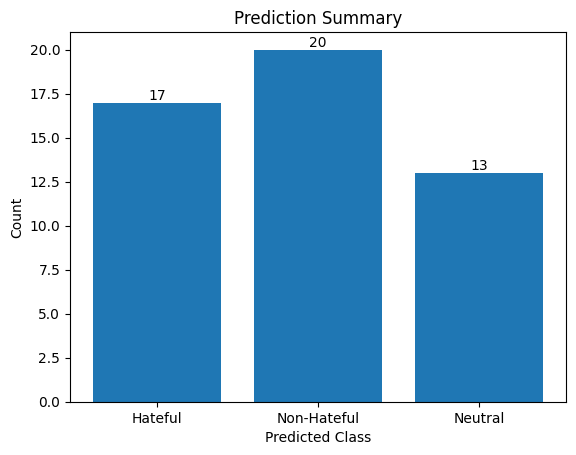

In [22]:
import matplotlib.pyplot as plt
MAX_SEQUENCE_LENGTH = 100
class_labels = ['Hateful', 'Non-Hateful', 'Neutral']
print(len(testCorpus))

# Load the model
loaded_model = tf.keras.models.load_model('savedModels/LSTM_Model')

# Make predictions on the padded sequences
predictions = loaded_model.predict(padded_sequences)
predicted_classes = np.argmax(predictions, axis=1)

# Count the predictions for each class
prediction_summary = {label: 0 for label in class_labels}
for predicted_class in predicted_classes:
    predicted_label = class_labels[predicted_class]
    prediction_summary[predicted_label] += 1

print(prediction_summary)
# Prepare data for bar chart
labels = list(prediction_summary.keys())
values = list(prediction_summary.values())

# Plot the bar chart
plt.bar(labels, values)
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.title('Prediction Summary')
for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()